In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show(img, title="", cmap=None):
    plt.figure(figsize=(6,5))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray", vmin=0, vmax=255)
    else:
        # OpenCV lit en BGR -> on convertit en RGB pour matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def to_gray(img_bgr):
    if img_bgr.ndim == 2:
        return img_bgr
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def clip_u8(x):
    return np.clip(x, 0, 255).astype(np.uint8)


In [53]:
def pad_image(img, pad, mode='reflect'):
    if pad == 0:
        return img
    if mode == 'constant':
        return np.pad(img, ((pad, pad), (pad, pad)) if img.ndim == 2 else ((pad, pad), (pad, pad), (0, 0)), mode ='constant', constant_values=0)
    elif mode == 'replicate':
        return np.pad(img, ((pad, pad), (pad, pad)) if img.ndim == 2 else ((pad, pad), (pad, pad), (0, 0)), mode ='edge')
    elif mode == 'reflect':
        return np.pad(img, ((pad, pad), (pad, pad)) if img.ndim == 2 else ((pad, pad), (pad, pad), (0, 0)), mode ='reflect')
    else:
        raise ValueError("type de bordure non supportée")

## Exercice 1 : Filtre moyenneur

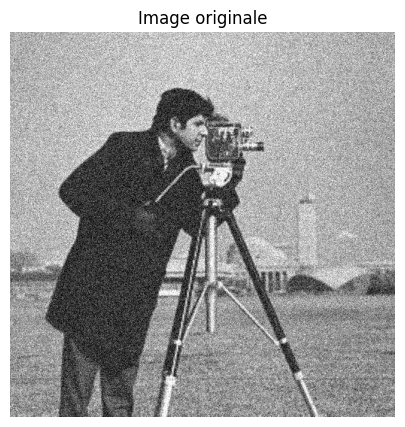

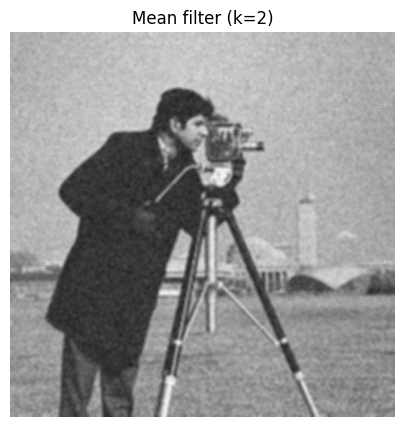

In [54]:
import cv2
import numpy as np
''' Implémentez le filtre moyenneur'''
def filtre_moy(gray, k, border = 'reflect'):

    assert gray.ndim == 2, "L'image doit etre en niveau de gris !"
    H, W = gray.shape
    win = 2*k +1 # taille de la fenetre
    pad = k # taille du padding
    g = pad_image(gray.astype(np.float32), pad, mode=border)
    
    out = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            patch = g[y:y+win, x:x+win]
            out[y, x] = np.mean(patch)

    return clip_u8(out)

    
img = cv2.imread("img/camera_bruit_gaussien.png")
gray = to_gray(img)
blur = filtre_moy(gray, k=2)
show(gray, title="Image originale")
show(blur, title="Mean filter (k=2)")

## Exercice 2 : Produit de convolution

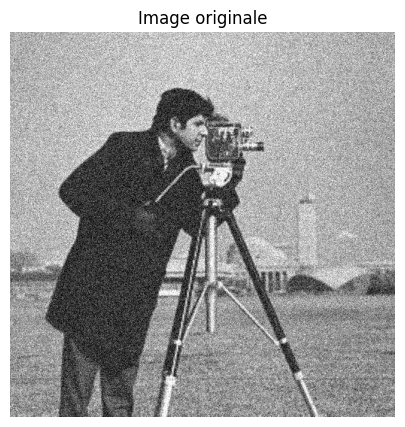

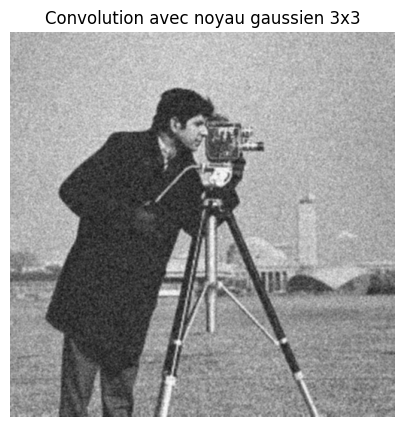

In [55]:
import cv2
import numpy as np

def produit_convolution(gray, kernel, border='reflect'):

    assert gray.ndim == 2, "L'image doit etre en niveau de gris !"
    Kh, Kw = kernel.shape
    assert Kh % 2 == 1 and Kw % 2 == 1, "le noyau doit avoir des dimensions impaires !"
    pad_y, pad_x = Kh // 2, Kw // 2 # taille du padding

    g = pad_image(gray.astype(np.float32), max(pad_y, pad_x), mode=border)

    g = np.pad(gray.astype(np.float32), ((pad_y, pad_y), (pad_x, pad_x)), mode=("reflect" if border=="reflect" else "edge" if border=="replicate" else "constant"))

    out = np.zeros(gray.shape, dtype=np.float32)

    kflip = np.flipud(np.fliplr(kernel.astype(np.float32)))  # flip the kernel

    H, W = gray.shape

    for y in range(H):
        for x in range(W):
            patch = g[y:y+Kh, x:x+Kw]
            out[y, x] = np.sum(patch * kflip)

    return out


mean3 = (1/9) * np.ones((3,3), dtype=np.float32)
gauss3 = (1/16) * np.array([[1,2,1], [2,4,2], [1,2,1]], dtype=np.float32)
sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]], dtype=np.float32)
laplacian = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32)

img = cv2.imread("img/camera_bruit_gaussien.png")
gray = to_gray(img)

res = produit_convolution(gray, gauss3)
show(gray, title="Image originale")
show(clip_u8(res), title="Convolution avec noyau gaussien 3x3")


## Exercice 3 - Détecteur de contours de Sobel

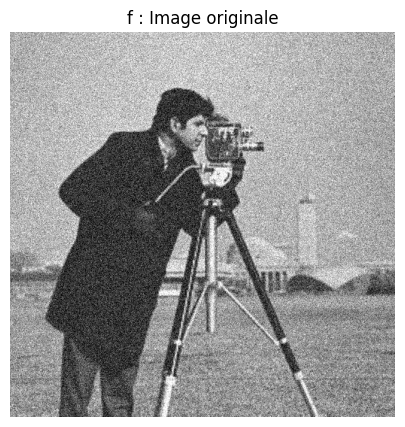

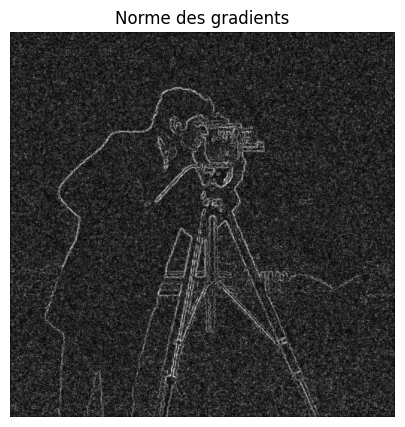

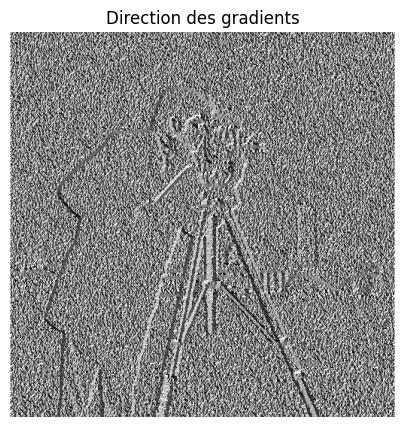

In [56]:
import cv2
import numpy as np

SOBEL_X = np.array([[-1,-2,-1], [0,0,0],[1,2,1]], dtype=np.float32)
SOBEL_Y = np.array([[1,0,-1], [2,0,-2], [1,0,-1]], dtype=np.float32)

def detection_sobel(gray, border="reflect", use_l1=True):

    Gx = produit_convolution(gray, SOBEL_X, border=border)
    Gy = produit_convolution(gray, SOBEL_Y, border= border)
    # norme 
    if use_l1:
        norme = np.abs(Gx) + np.abs(Gy)
    else:
        norme = np.sqrt(Gx*Gx + Gy*Gy) # norme euclidienne

    norme_vis = norme / (norme.max() + 1e-9) * 255.0
    
    # direction des gradients 
    dir = np.arctan2(Gy, Gx)
    dir_vis = ((dir + np.pi) / (2*np.pi) * 255.0).astype(np.uint8)

    return norme_vis, dir_vis



img = cv2.imread("img/camera_bruit_gaussien.png")
gray = to_gray(img)

norme, dir_vis = detection_sobel(gray, use_l1=True)

show(gray, title="f : Image originale")
show(norme, title = "Norme des gradients")
show(dir_vis, title = "Direction des gradients")
    

## Exercice 4 : Filtre bilatéral

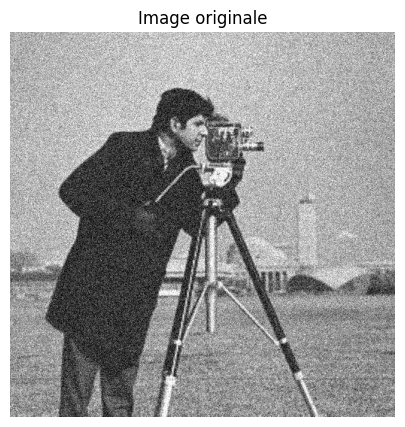

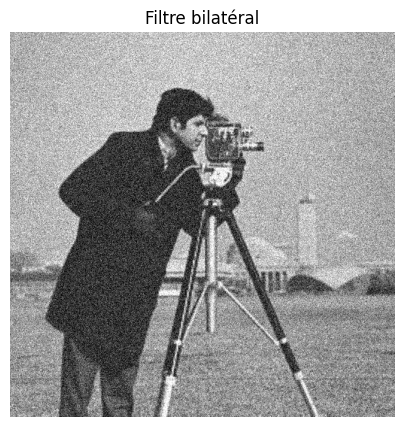

In [57]:
import cv2
import numpy as np

def bilateral_filter(gray, k, sigma_space, sigma_range, border="reflect"):

    assert gray.ndim == 2
    H, W = gray.shape
    win = 2*k + 1
    pad = k

    g =pad_image(gray.astype(np.float32), pad, mode=border)

    # Grille pour le poids spatial 
    Ys, Xs = np.mgrid[-k:k+1, -k:k+1].astype(np.float32)
    spatial = np.exp(-(Xs*Xs + Ys*Ys) / (2*sigma_space*sigma_range))

    out = np.zeros((H,W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            patch = g[y:y+win, x:x+win]
            center = g[y+k, x+k]
            range_w = np.exp(-((patch - center)**2) / (2*sigma_range*sigma_range))
            w = spatial * range_w
            out[y, x] = np.sum(w * patch) / (np.sum(w) + 1e-9)

    return clip_u8(out)

img = cv2.imread("img/camera_bruit_gaussien.png")
gray = to_gray(img)

bf = bilateral_filter(gray, k=3, sigma_space=2.0, sigma_range=25.0)
show(gray, title="Image originale")
show(gray, "Filtre bilatéral")

## Exercice 5 : Filtre médian

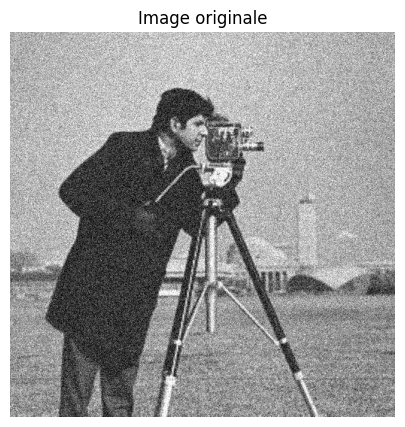

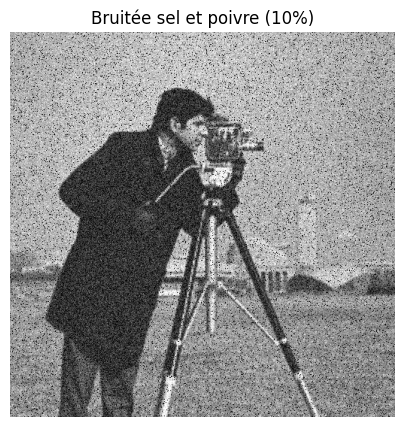

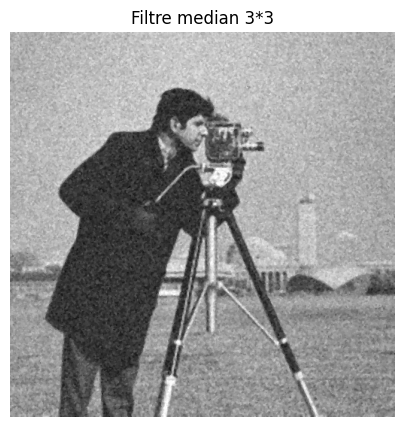

In [51]:
import cv2
import numpy as np

def bruit_sel_poivre(gray, p=10.0):
    assert gray.ndim == 2
    noisy = gray.copy()

    H, W = gray.shape
    N = H * W
    n = int(p*N)

    idx = np.random.choice(N, n, replace=False)

    half = n //2
    noisy.flat[idx[:half]] = 255
    noisy.flat[idx[:half]] = 0

    return noisy


def median_filter(gray, k, border="reflect"):
    assert gray.ndim == 2
    H, W = gray.shape
    win = 2*k + 1 
    pad = k 

    g = pad_image(gray, pad, mode=border)
    out = np.zeros((H, W), dtype=np.uint8)

    for y in range(H):
        for x in range(W):
            patch = g[y:y+win, x:x+win].reshape(-1)
            out[y, x] = np.median(patch)

    return out

img = cv2.imread("img/camera_bruit_gaussien.png")
gray = to_gray(img)

bruit = bruit_sel_poivre(gray, p=0.10) # bruitée du sel et poivre à 10 %
med = median_filter(gray, k=1) # 3*3

show(gray, title="Image originale")
show(bruit, title="Bruitée sel et poivre (10%)")
show(med, title="Filtre median 3*3")
